In [1]:
import numpy as np
import pandas as pd


# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [3]:
meta_activity_map_file = "/data5/deepro/starrseq/papers/results/2_categorize_fragments_on_activity/data/meta_activity_map.csv"

In [4]:
df = pd.read_csv(meta_activity_map_file, index_col="chrom_coord")
df =  df.fillna(df.median())

In [5]:
libs = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

# All library fragment categories

In [6]:
def get_fragment_categories(df, libs):
    unresponsive_cond = " & ".join([f"(`{lib}_padj` > 0.05)" for lib in libs])
    induced_cond = "(" + " | ".join([f"(`{lib}_padj` < 0.05) & (`{lib}_log2FoldChange` > 0)" for lib in libs]) + ")" 
    repressed_cond = "(" + " | ".join([f"(`{lib}_padj` < 0.05) & (`{lib}_log2FoldChange` < 0)" for lib in libs]) + ")" 
    active_induced_cond = "(`CC_peak` == 1) & " + "(" + " | ".join([f"(`{lib}_padj` < 0.05) & (`{lib}_peak` == 1) & (`{lib}_log2FoldChange` > 0)" for lib in libs]) + ")" 
    gained_cond = "(`CC_peak` == 0) & " + "(" + " | ".join([f"(`{lib}_padj` < 0.05) & (`{lib}_peak` == 1) & (`{lib}_log2FoldChange` > 0)" for lib in libs]) + ")" 
    lost_cond = "(`CC_peak` == 1) & " + "(" + " | ".join([f"(`{lib}_padj` < 0.05) & (`{lib}_peak` == 0) & (`{lib}_log2FoldChange` < 0)" for lib in libs]) + ")" 
    always_active_cond =  "(`CC_peak` == 1) & " +  " & ".join([f"(`{lib}_peak` == 1)" for lib in libs]) 
    always_inactive_cond =  "(`CC` < -1) & " +  " & ".join([f"(`{lib}` < -1)" for lib in libs]) 

    unresponsive_fragments = df.query(unresponsive_cond)
    induced_fragments = df.query(induced_cond)
    repressed_fragments = df.query(repressed_cond)
    active_induced_fragments = df.query(active_induced_cond)
    always_active_fragments = df.query(always_active_cond)
    always_inactive_fragments = df.query(always_inactive_cond)
    gained_fragments = df.query(gained_cond)
    lost_fragments = df.query(lost_cond)

    maxCol=lambda x: max(x.min(), x.max(), key=abs)
    unresponsive_fragments["abs_mean_fc"] = unresponsive_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].mean(axis=1)
    induced_fragments["abs_max_fc"] = induced_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].max(axis=1)
    repressed_fragments["abs_max_fc"] = repressed_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].min(axis=1)
    active_induced_fragments["abs_max_fc"] = active_induced_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].max(axis=1)
    always_active_fragments["abs_max_fc"] = always_active_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].median(axis=1) #.apply(maxCol,axis=1)
    always_inactive_fragments["abs_max_fc"] = always_inactive_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].median(axis=1) #.apply(maxCol,axis=1)
    gained_fragments["abs_max_fc"] = gained_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].max(axis=1)
    lost_fragments["abs_max_fc"] = lost_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].min(axis=1)
    return unresponsive_fragments, induced_fragments, repressed_fragments, always_active_fragments, always_inactive_fragments, gained_fragments, lost_fragments

In [7]:
def plot_fragment_category(
    unresponsive_fragments, induced_fragments, repressed_fragments, always_active_fragments, always_inactive_fragments, gained_fragments, lost_fragments, 
    sf=4, figsize=(8, 10), xlim=(-4, 4), ylim=(-5, 6), plot_active_inactive=True):
    fig, axes = plt.subplots(figsize=figsize)
    sns.scatterplot(data=unresponsive_fragments, y="CC", x="abs_mean_fc", s=1*sf, alpha=0.2, color="grey", ax=axes, rasterized=True)
    sns.scatterplot(data=induced_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.25, color="green", ax=axes, rasterized=True)
    sns.scatterplot(data=repressed_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.25, color="red", ax=axes, rasterized=True)
    sns.scatterplot(data=gained_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.5, color="navy", ax=axes, rasterized=True)
    sns.scatterplot(data=lost_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.5, color="k", ax=axes, rasterized=True)
    if plot_active_inactive:
        sns.scatterplot(data=always_active_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.5, color="gold", ax=axes, rasterized=True)
        sns.scatterplot(data=always_inactive_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.5, color="tan", ax=axes, rasterized=True)
    axes.axhline(0, color="k")
    axes.axvline(0.25, color="k", ls="--")
    axes.axvline(-0.25, color="k", ls="--")
    # axes.set_xlim(*xlim)
    # axes.set_ylim(*ylim)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Unresponsive', markerfacecolor='grey', markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Induced', markerfacecolor='green', markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Repressed', markerfacecolor='red', markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Gained', markerfacecolor='navy', markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Lost', markerfacecolor='k', markersize=15),
        ]
    if plot_active_inactive:
        legend_elements.extend([
            Line2D([0], [0], marker='o', color='w', label='Always active', markerfacecolor='gold', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='Always inactive', markerfacecolor='tan', markersize=15),
        ])
    axes.spines[['right', 'top']].set_visible(False)
    axes.legend(handles=legend_elements, loc='lower right', frameon=False)
    axes.set_xlabel("Response")
    axes.set_ylabel("Activity in control")
    return fig, axes

In [8]:
unresponsive_fragments, induced_fragments, repressed_fragments, always_active_fragments, always_inactive_fragments, gained_fragments, lost_fragments = get_fragment_categories(df, libs[:-1])

/tmp/ipykernel_3756198/2434967235.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unresponsive_fragments["abs_mean_fc"] = unresponsive_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].mean(axis=1)
/tmp/ipykernel_3756198/2434967235.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  induced_fragments["abs_max_fc"] = induced_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].max(axis=1)
/tmp/ipykernel_3756198/2434967235.py:23: SettingWithCopyWarning: 
A value is trying to be set on a

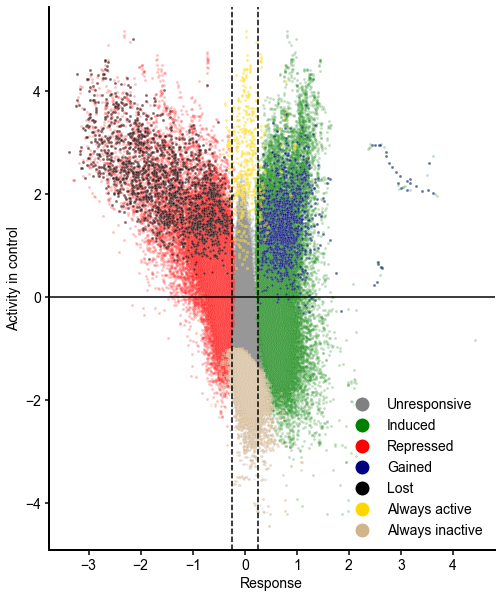

In [9]:
fig, ax = plot_fragment_category(unresponsive_fragments, induced_fragments, repressed_fragments, always_active_fragments, always_inactive_fragments, gained_fragments, lost_fragments)

In [10]:
save_file = f"../data/figures/fragment_categories/fragment_categories.pdf"
save_pdf(save_file, fig)

# Per library fragment categories

/tmp/ipykernel_3756198/2434967235.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unresponsive_fragments["abs_mean_fc"] = unresponsive_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].mean(axis=1)
/tmp/ipykernel_3756198/2434967235.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  induced_fragments["abs_max_fc"] = induced_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].max(axis=1)
/tmp/ipykernel_3756198/2434967235.py:23: SettingWithCopyWarning: 
A value is trying to be set on a

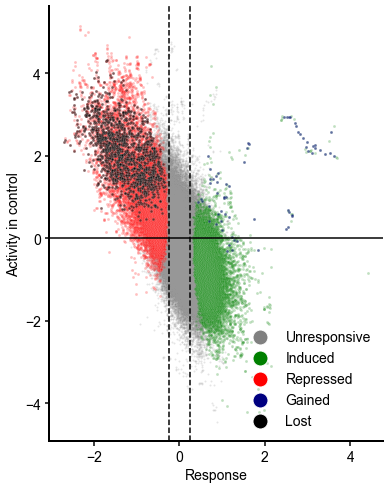

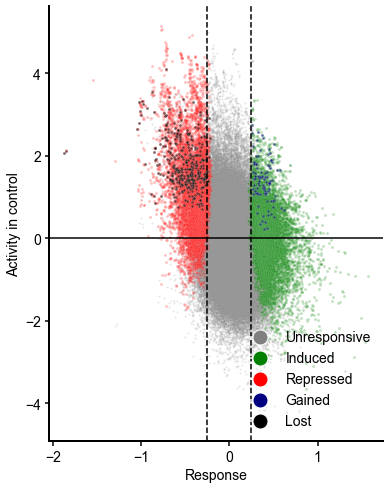

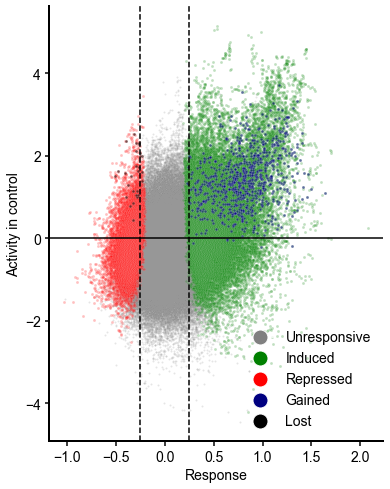

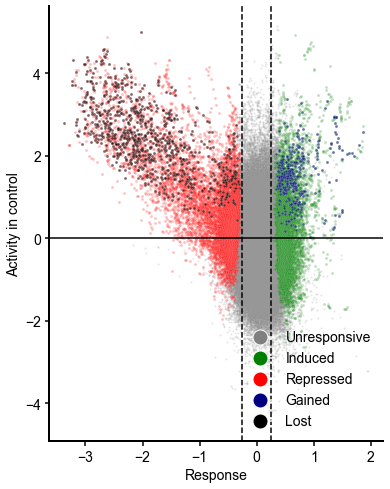

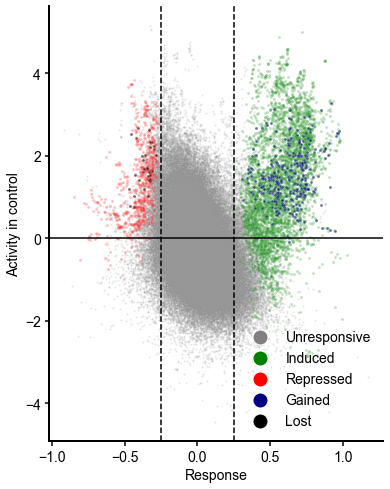

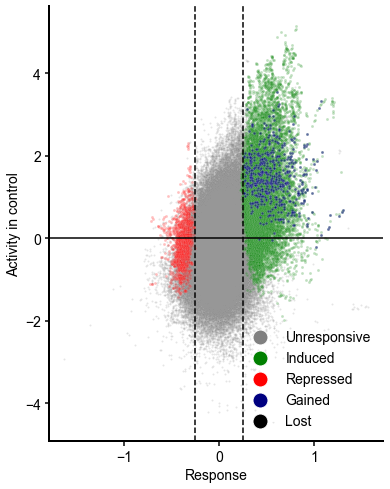

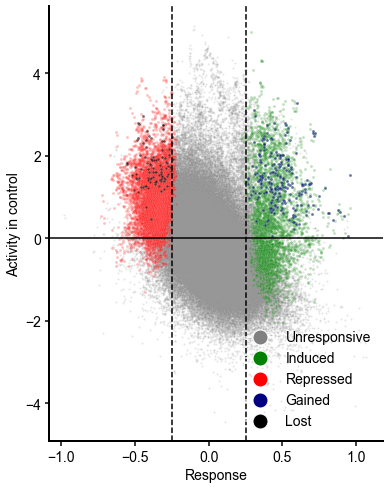

In [11]:
for lib in libs:
    unresponsive_fragments, induced_fragments, repressed_fragments, always_active_fragments, always_inactive_fragments, gained_fragments, lost_fragments = get_fragment_categories(df, [lib])
    fig, ax = plot_fragment_category(unresponsive_fragments, induced_fragments, repressed_fragments, always_active_fragments, always_inactive_fragments, gained_fragments, lost_fragments, plot_active_inactive=False, figsize=(6,8))
    save_file = f"../data/figures/fragment_categories/{lib}_fragment_categories.pdf"
    save_pdf(save_file, fig)
